# A Text Mining Approach to Analyze The Cyber Security Related Articles

## PART-3: Text Mining

__Feature Engineering with NLP techniques__


__Importing of Required Libraries__

In [1]:
import nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
import pickle
import re


import spacy
import en_core_web_sm
from spacy import displacy

import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

__Loading Data__

As mentioned Part-2 that pandas parquet options doesn't support timedelta type. So we need to use __fastparquet__ option, to keep the timedelta type format.

In [2]:
df_sum=pd.read_parquet('df_sum_parquet.gzip',engine='fastparquet')
df_investigator_cyber=pd.read_parquet('df_investigator_cyber_parque.gzip',engine='fastparquet')
df_sum.head(2)

,AwardID,AwardTitle,AwardEffectiveDate,AwardExpirationDate,AwardAmount,ProgramOfficer,Institution_Name,Institution_StateName,Abstract,Year,Award_Duration,AwardAmount_Million,Abstract_Lenght
0,0110599,Collaborative Research Testing Affect Control ...,2001-08-15,2004-07-31,300000.0,Patricia White,University of Arizona,Arizona,The investigators will conduct a series of exp...,2001,1081 days,0.30,2194
1,0112426,Federal Cyber Service Initiative,2001-06-01,2007-06-30,149995.0,Timothy V. Fossum,University of Tulsa,Oklahoma,This program produces a cadre of computer scie...,2001,2220 days,0.15,765


### A-) Word Frequency

__Replacing Of Contraction Words__

In [3]:
#Replace contraction words to alternative forms before tokenization
replacement_patterns = {
    r"won\'t": "will not",
    r"can\'t": "cannot",
    r"i\'m": "i am",
    r"ain\'t": "is not",
    r"(\w+)\'ll": "\g<1> will",
    r"(\w+)n\'t": "\g<1> not",
    r"(\w+)\'ve": "\g<1> have",
    r"(\w+)\'s": "\g<1> is",
    r"(\w+)\'re": "\g<1> are",
    r"(\w+)\'d": "\g<1> would",
    r"&": "and",
    r"<br/>":" "}

df_sum['Abstract']=df_sum['Abstract'].replace(replacement_patterns, regex=True)
df_sum.head(2)

,AwardID,AwardTitle,AwardEffectiveDate,AwardExpirationDate,AwardAmount,ProgramOfficer,Institution_Name,Institution_StateName,Abstract,Year,Award_Duration,AwardAmount_Million,Abstract_Lenght
0,0110599,Collaborative Research Testing Affect Control ...,2001-08-15,2004-07-31,300000.0,Patricia White,University of Arizona,Arizona,The investigators will conduct a series of exp...,2001,1081 days,0.30,2194
1,0112426,Federal Cyber Service Initiative,2001-06-01,2007-06-30,149995.0,Timothy V. Fossum,University of Tulsa,Oklahoma,This program produces a cadre of computer scie...,2001,2220 days,0.15,765


__Merge All Values in Abstract Columns to A Single String__

In [4]:
abstract_list=df_sum['Abstract'].tolist()
abstract_sum=' '.join(abstract_list)
print('Total character number of all Abstract columns is: {}'.format(len(abstract_sum)))

Total character number of all Abstract columns is: 11265082


__Tokenization and LowerCase__

In [5]:
#word tokenization
wrd_list = nltk.word_tokenize(abstract_sum)

#lowercase
wrd_list=[w.lower() for w in wrd_list]
print('Total lowercase words: {}'.format(len(wrd_list)))

Total lowercase words: 1765676


__Remove Numbers__

In [6]:
#remove numbers
wrd_list_alpha=[w for w in wrd_list if w.isalpha()]
print('Total words consist of only alphabets: {}'.format(len(wrd_list_alpha)))

Total words consist of only alphabets: 1532313


__Remove Written Form of Numbers__

In [7]:
#Create numbers in written form for ignoring
num_written= {1: 'one', 2: 'two', 3: 'three', 4: 'four', 5: 'five', \
             6: 'six', 7: 'seven', 8: 'eight', 9: 'nine', 10: 'ten', \
            11: 'eleven', 12: 'twelve', 13: 'thirteen', 14: 'fourteen', \
            15: 'fifteen', 16: 'sixteen', 17: 'seventeen', 18: 'eighteen', \
            19: 'nineteen', 20: 'twenty', 30: 'thirty', 40: 'forty', \
            50: 'fifty', 60: 'sixty', 70: 'seventy', 80: 'eighty', \
            90: 'ninety', 0: 'zero'}

num_list=list(np.arange(0,100))

num2words_list=[]

def num2words(n):
    try:
        return num_written[n]
    except:
        try:
            return num2words(n-n%10) + num2words(n%10)
        except:
            return 'None'

        
for num in num_list:
    num2words_list.append(num2words(num))
    
wrd_list_rm_written_form = [w for w in wrd_list_alpha if w not in num2words_list]
print('Total words consist of only alphabets: {}'.format(len(wrd_list_rm_written_form)))

Total words consist of only alphabets: 1527908


__Remove Stopwords__

In [8]:
#define stopwords list
stopwords_list=nltk.corpus.stopwords.words('english')

#extend the stopwords list
stopwords_list.extend(['cannot','many','much','also','well','better','via'])

wrd_list_rm_stopwords = [w for w in wrd_list_rm_written_form if w not in stopwords_list]
print('Total words after removing stopwords: {}'.format(len(wrd_list_rm_stopwords)))

Total words after removing stopwords: 936335


__Remove 1-Length Words__

In [9]:
#remove 1-len words
wrd_list_one_len = [w for w in wrd_list_rm_stopwords if len(w)>=2]

print('Total words after removing 1-len words: {}'.format(len(wrd_list_one_len)))

Total words after removing 1-len words: 935577


__Counting The Words Frequency__

In [10]:
freq_dict_before=nltk.FreqDist(wrd_list_one_len)
print('Total unique words before lemmatization: {}'.format(len(freq_dict_before)))

Total unique words before lemmatization: 25204


In [11]:
print('First 50 frequency words:\n{}'.format(freq_dict_before.most_common(50)))

First 50 frequency words:
[('research', 13368), ('project', 11564), ('data', 9591), ('students', 6695), ('systems', 6029), ('science', 5818), ('new', 5583), ('security', 3842), ('support', 3592), ('development', 3556), ('system', 3538), ('community', 3537), ('information', 3485), ('education', 3409), ('program', 3367), ('learning', 3334), ('engineering', 3166), ('university', 3126), ('cyberinfrastructure', 2987), ('software', 2973), ('design', 2966), ('network', 2899), ('develop', 2867), ('using', 2847), ('use', 2817), ('tools', 2793), ('cybersecurity', 2770), ('provide', 2713), ('computing', 2629), ('researchers', 2506), ('scientific', 2475), ('nsf', 2431), ('computational', 2419), ('technology', 2393), ('computer', 2337), ('infrastructure', 2291), ('national', 2215), ('broader', 2196), ('materials', 2153), ('cyber', 2139), ('award', 2091), ('work', 2066), ('activities', 2042), ('including', 2041), ('analysis', 2022), ('control', 1987), ('applications', 1975), ('resources', 1940), ('m

__Lemmatization__

In [12]:
#Lemmatization
lemmatizer = WordNetLemmatizer()

wrd_list_lemmas = [lemmatizer.lemmatize(w) for w in wrd_list_one_len]

#Recounting the Words Frequency
freq_dict=nltk.FreqDist(wrd_list_lemmas)

print('Total unique words after lemmatization: {}'.format(len(freq_dict)))


Total unique words after lemmatization: 22290


In [13]:
#Most common words
print('First 50 frequency words:\n{}'.format(freq_dict.most_common(50)))

First 50 frequency words:
[('research', 13374), ('project', 12881), ('data', 9591), ('system', 9567), ('student', 7861), ('science', 6785), ('new', 5583), ('program', 4688), ('community', 4631), ('network', 4451), ('support', 4268), ('technology', 3977), ('security', 3842), ('development', 3748), ('impact', 3693), ('university', 3676), ('information', 3485), ('model', 3446), ('education', 3411), ('tool', 3348), ('learning', 3334), ('design', 3218), ('engineering', 3166), ('cyberinfrastructure', 2987), ('software', 2975), ('develop', 2867), ('using', 2847), ('application', 2837), ('use', 2817), ('cybersecurity', 2770), ('provide', 2713), ('computing', 2629), ('resource', 2604), ('infrastructure', 2604), ('researcher', 2592), ('computer', 2586), ('material', 2532), ('scientific', 2475), ('activity', 2450), ('nsf', 2433), ('computational', 2419), ('workshop', 2399), ('approach', 2285), ('analysis', 2282), ('national', 2215), ('broader', 2196), ('award', 2180), ('work', 2154), ('cyber', 21

In [92]:
#A specific word
print("The frequency of word 'internet': {}".format(freq_dict['internet']))

The frequency of word 'internet': 731


__Saving The Result__

In [14]:
df_FreqDist=pd.DataFrame({'Words':list(freq_dict.keys()),'Count':list(freq_dict.values())})
df_FreqDist.sort_values(by=['Count'],ascending=False,inplace=True)
df_FreqDist=df_FreqDist.reset_index(drop=True)
df_FreqDist.to_csv('FreqDist.csv', sep=';')
df_FreqDist.head(3)

,Words,Count
0,research,13374
1,project,12881
2,data,9591


## B-) Clustering and Topic Modeling

In [124]:
#Create a new DataFrame
df_sum2=df_sum[['AwardID','AwardTitle','Abstract']]
df_sum2.head(2)

,AwardID,AwardTitle,Abstract
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a series of exp...
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...


__Replacing Of Contraction Words__

In [125]:
replacement_patterns = {
    r"won\'t": "will not",
    r"can\'t": "cannot",
    r"i\'m": "i am",
    r"ain\'t": "is not",
    r"(\w+)\'ll": "\g<1> will",
    r"(\w+)n\'t": "\g<1> not",
    r"(\w+)\'ve": "\g<1> have",
    r"(\w+)\'s": "\g<1> is",
    r"(\w+)\'re": "\g<1> are",
    r"(\w+)\'d": "\g<1> would",
    r"&": "and",
    r"<br/>":" "}

df_sum2['Abstract'].replace(replacement_patterns, regex=True, inplace=True)
df_sum2.head(2)

,AwardID,AwardTitle,Abstract
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a series of exp...
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...


__Removing Unneccesery Words__

We use __NER__ (Named Entity Recognition) function of __spacy__ library to detect named entities (people, places, organizations, dates, times etc.) from the text. After analyzing this words, we understood that they are unnecessary for clustering.

An example of visualization of NER:

In [126]:
#define the nlp object
nlp = en_core_web_sm.load()

doc=nlp(str(df_sum2['Abstract'][1]))

displacy.render(doc, style="ent",jupyter=True)

In [127]:
#create a list for NER
NER_list=[]

#Find
for n in range(df_sum2.shape[0]):
    doc=nlp(str(df_sum2['Abstract'][n]))

    for ent in doc.ents:
        NER_list.append(ent.text)
        
NER_list = [' {0} '.format(elem) for elem in NER_list] #Add space to begins and ends of all NERs

print('Total NER words: {}'.format(len(NER_list)))
NER_list=list(set(NER_list)) #for unique elements in list
print('Total unique NER words: {}'.format(len(NER_list)))

print('Total words before removing NER: {}'.format(sum(df_sum2['Abstract'].str.len())))

for NER in NER_list:
    df_sum2['Abstract']=df_sum2['Abstract'].str.replace(NER,' ',regex=False) #Because,some NERs have punctuation
print('Total words after removing NER: {}'.format(sum(df_sum2['Abstract'].str.len())))

Total NER words: 64756
Total unique NER words: 18582
Total words before removing NER: 11260530
Total words after removing NER: 10506240


__Tokenization and LowerCase__

In [128]:
#word tokenization and lowercase
df_sum2['Abstract_Tokens'] = df_sum2['Abstract'].str.lower().apply(nltk.word_tokenize)
print('Total words: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words: 1662401


,AwardID,AwardTitle,Abstract,Abstract_Tokens
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"[the, investigators, will, conduct, a, of, exp..."
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"[this, program, produces, a, cadre, of, comput..."


__Remove Numbers__

In [129]:
#remove numbers
for n in range(df_sum2.shape[0]):
    #print(n)
    df_sum2['Abstract_Tokens'][n]=[w for w in df_sum2['Abstract_Tokens'][n] if w.isalpha()]
print('Total words consist of only alphabets: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words consist of only alphabets: 1437802


,AwardID,AwardTitle,Abstract,Abstract_Tokens
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"[the, investigators, will, conduct, a, of, exp..."
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"[this, program, produces, a, cadre, of, comput..."


__Remove Stopwords__

In [130]:
#define stopwords list
stopwords_list=nltk.corpus.stopwords.words('english')

#extend the stopwords list
stopwords_list.extend(['cannot','many','much','also','well','better','via','able'])

#extend the stopwords list with unneccessary words for this study
stopwords_list.extend(['abstract','program','pi'])


for n in range(df_sum2.shape[0]):
    df_sum2['Abstract_Tokens'][n]=[w for w in df_sum2['Abstract_Tokens'][n] if w not in stopwords_list]
print('Total words after removing stopwords: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words after removing stopwords: 848752


,AwardID,AwardTitle,Abstract,Abstract_Tokens
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"[investigators, conduct, experiments, focus, c..."
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"[produces, cadre, computer, scientists, strong..."


__Lemmatization with POS Tag__

In [131]:
#define lemmatizer() object
lemmatizer = WordNetLemmatizer()

#lemmatize with POS Tag
def get_wordnet_pos(word):
    #Map POS tag to first character lemmatize() accepts
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


for n in range(df_sum2.shape[0]):
    df_sum2['Abstract_Tokens'][n]=[lemmatizer.lemmatize(w,get_wordnet_pos(w)) for w in df_sum2['Abstract_Tokens'][n]]

print('Total words after lemmatization: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words after lemmatization: 848752


,AwardID,AwardTitle,Abstract,Abstract_Tokens
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"[investigator, conduct, experiment, focus, cru..."
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"[produce, cadre, computer, scientist, strong, ..."


__Remove 1-Length Words__

Punctuation
Punctuation are the unnecessary symbols that are in our corpus documents,

In [132]:
#remove 1-len words
for n in range(df_sum2.shape[0]):
    df_sum2['Abstract_Tokens'][n]=[w for w in df_sum2['Abstract_Tokens'][n] if len(w)>=2]
print('Total words after removing 1-len words: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words after removing 1-len words: 847894


,AwardID,AwardTitle,Abstract,Abstract_Tokens
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"[investigator, conduct, experiment, focus, cru..."
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"[produce, cadre, computer, scientist, strong, ..."


In [123]:
url='https://raw.githubusercontent.com/dwyl/english-words/master/words_alpha.txt'
data = pd.read_csv(url,  header=None)
wordlist=list(data[0].values)
len(wordlist)

370104

In [133]:
#Creat a wordlist
url='https://raw.githubusercontent.com/dwyl/english-words/master/words_alpha.txt'
data = pd.read_csv(url,  header=None)
wordlist=list(data[0].values)

meaningless_list=[]

#Check the tokens from wordlist
for n in range(df_sum2.shape[0]):
    meaningless=[w for w in  df_sum2['Abstract_Tokens'][n] if w not in wordlist]
    meaningless_list.extend(meaningless)
    df_sum2['Abstract_Tokens'][n]=[w for w in  df_sum2['Abstract_Tokens'][n] if w in wordlist]
print('Total words after removing the meaningless words: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words after removing the meaningless words: 823027


,AwardID,AwardTitle,Abstract,Abstract_Tokens
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"[investigator, conduct, experiment, focus, cru..."
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"[produce, cadre, computer, scientist, strong, ..."


In [134]:
print(set(meaningless_list))

{'cmi', 'nicoya', 'venkatesh', 'hantavirus', 'fnirs', 'dmrg', 'wabash', 'photochromes', 'atp', 'jantke', 'autostereoscopic', 'wais', 'yeung', 'tandd', 'pna', 'uconn', 'fsafe', 'filesender', 'iacbp', 'magnetoencephalography', 'compositionality', 'byod', 'databasing', 'conversim', 'aquaponics', 'ntp', 'streamwise', 'sserca', 'ebam', 'pleth', 'sandt', 'ccc', 'activies', 'stnos', 'metastructure', 'logothetis', 'virtualized', 'nrdc', 'vectorbase', 'uw', 'quadrotors', 'qw', 'mudslide', 'rbdil', 'faultlines', 'zetabytes', 'lipon', 'ciac', 'operationalization', 'qedc', 'rcn', 'stereoselective', 'sfsu', 'chikyu', 'byu', 'iffs', 'pnetcdf', 'belarbi', 'systemof', 'bronfenbrenner', 'plae', 'mgp', 'disbaled', 'overnights', 'biocomputation', 'cipres', 'infotainment', 'registerd', 'ayman', 'seddb', 'reputational', 'competitivity', 'mellanox', 'msi', 'uno', 'dimatia', 'francesco', 'planetlab', 'blueroof', 'chipset', 'shepens', 'synergizing', 'http', 'sepm', 'cyberstem', 'supersymmetric', 'buell', 'oax

__Remove Meaningless Words__

In [24]:
wordlist = nltk.corpus.words.words()#Creat a wordlist
meaningless_list=[]

#Check the tokens from wordlist
for n in range(df_sum2.shape[0]):
    meaningless=[w for w in  df_sum2['Abstract_Tokens'][n] if w not in wordlist]
    meaningless_list.extend(meaningless)
    df_sum2['Abstract_Tokens'][n]=[w for w in  df_sum2['Abstract_Tokens'][n] if w in wordlist]
print('Total words after removing the meaningless words: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words after removing the meaningless words: 783935


,AwardID,AwardTitle,Abstract,Abstract_Tokens
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"[investigator, conduct, experiment, focus, cru..."
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"[produce, cadre, computer, scientist, strong, ..."


In [93]:
print(set(meaningless_list))

{'cmi', 'nicoya', 'venkatesh', 'hantavirus', 'uncovers', 'multichannel', 'delaware', 'unencrypted', 'fnirs', 'dmrg', 'depends', 'heightens', 'wabash', 'photochromes', 'externship', 'magmatism', 'atp', 'jantke', 'autostereoscopic', 'milan', 'wais', 'yeung', 'tandd', 'pna', 'anytime', 'uconn', 'fsafe', 'eng', 'filesender', 'iacbp', 'ron', 'evaluates', 'delayed', 'baryon', 'magnetoencephalography', 'compositionality', 'byod', 'databasing', 'georgia', 'conversim', 'wider', 'aquaponics', 'ntp', 'streamwise', 'sserca', 'ebam', 'gaussian', 'pleth', 'sandt', 'ccc', 'makeup', 'atlantis', 'activies', 'eugene', 'stnos', 'metastructure', 'logothetis', 'bursty', 'arbitrage', 'virtualized', 'bakersfield', 'intergroup', 'nrdc', 'vectorbase', 'uw', 'quadrotors', 'qw', 'mudslide', 'rbdil', 'faultlines', 'formalizes', 'zetabytes', 'lipon', 'ciac', 'ald', 'operationalization', 'qedc', 'rcn', 'ricky', 'stereoselective', 'sfsu', 'decrypts', 'chikyu', 'byu', 'iffs', 'nazarene', 'pnetcdf', 'belarbi', 'system

In [147]:
lemmatizer.lemmatize('reseachers','n')

'reseachers'

In [143]:
'cyberthreat' in wordlist

False

Abstract2 uniqi!!!
#Recounting the Words Frequency
freq_dict=nltk.FreqDist(wrd_list_lemmas)

print('Total unique words after lemmatization: {}'.format(len(freq_dict)))


__Convert Tokens To String Again__

In [148]:
df_sum2['Abstract2']=df_sum2['Abstract']
for n in range(df_sum2.shape[0]):
    df_sum2['Abstract2'][n]=' '.join([str(item) for item in df_sum2['Abstract_Tokens'][n]])
df_sum2.head(2)

,AwardID,AwardTitle,Abstract,Abstract_Tokens,Abstract2
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"[investigator, conduct, experiment, focus, cru...",investigator conduct experiment focus crucial ...
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"[produce, cadre, computer, scientist, strong, ...",produce cadre computer scientist strong specia...


__TfidfVectorizer__

In [149]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
X = v.fit_transform(df_sum2['Abstract2'])
X.toarray()[:2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [150]:
v.get_feature_names()[:10]

['aa',
 'aaa',
 'ab',
 'abandonment',
 'abdomen',
 'aberrant',
 'abet',
 'abide',
 'ability',
 'abiotic']

In [151]:
len(v.vocabulary_)

13065

__Create New DataFrame__

In [152]:
df = pd.DataFrame(data=X.toarray(), columns=v.get_feature_names())
df.head(2)

,aa,aaa,ab,abandonment,abdomen,aberrant,abet,abide,ability,abiotic,...,zircon,zonal,zone,zoo,zoological,zoom,zoonotic,zooplankton,zurich,zwitterionic
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


__Add The Top Word To Row__

In [153]:
df_sum2['Top_Word']=df.idxmax(axis=1)
df_sum2['Top_Word_Freq']=df.max(axis=1)
df_sum2.head(5)

,AwardID,AwardTitle,Abstract,Abstract_Tokens,Abstract2,Top_Word,Top_Word_Freq
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"[investigator, conduct, experiment, focus, cru...",investigator conduct experiment focus crucial ...,restorative,0.601884
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"[produce, cadre, computer, scientist, strong, ...",produce cadre computer scientist strong specia...,assurance,0.354720
2,0114016,Cyber Service Training and Education,This project relieves the shortage of qualifie...,"[project, relief, shortage, qualify, informati...",project relief shortage qualify information as...,assurance,0.393875
3,0133664,CAREER: Algorithms for Efficient Bandwidth Uti...,There is a growing scientific community workin...,"[grow, scientific, community, work, provide, s...",grow scientific community work provide solid t...,compression,0.383257
4,0140179,Experimental Study of Adaptation to the Edge o...,0140179 aspect of biocomplexity is the abili...,"[aspect, ability, biota, environment, previous...",aspect ability biota environment previous stud...,chaotic,0.372620


__KMeans Clustering__

Modeling with k-means: 1 is finish...
Modeling with k-means: 2 is finish...
Modeling with k-means: 3 is finish...
Modeling with k-means: 4 is finish...
Modeling with k-means: 5 is finish...


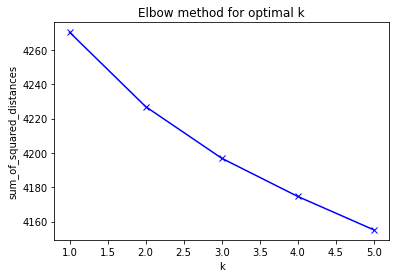

In [154]:

#for each value of k, we can initialise k_means and use inertia to identify the sum of squared distances of samples to the nearest cluster centre
sum_of_squared_distances = []

K_top=6 #
K = range(1,K_top)
for k in K:
    k_means = KMeans(n_clusters=k)
    model = k_means.fit(df)
    sum_of_squared_distances.append(k_means.inertia_)
    print('Modeling with k-means: {} is finish...'.format(k))
    
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow method for optimal k')
plt.show()

In [155]:
[j-i for i, j in zip(sum_of_squared_distances[:-1], sum_of_squared_distances[1:])]

[-43.294301291260126,
 -30.066514377478597,
 -22.24147452563193,
 -19.456530441090763]

In [156]:
n_clusters=3

In [157]:

k_means = KMeans(n_clusters=n_clusters)
#Run the clustering algorithm
model = k_means.fit(df)
#Generate cluster predictions and store in y_hat
y_hat = k_means.predict(X)
y_hat

array([2, 0, 0, ..., 2, 2, 0])

In [158]:
labels=list(y_hat)
df_sum2['Label']=labels
df_sum2.to_csv('df_sum_clustering.csv',sep=';')
df_sum2.head(2)

,AwardID,AwardTitle,Abstract,Abstract_Tokens,Abstract2,Top_Word,Top_Word_Freq,Label
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"[investigator, conduct, experiment, focus, cru...",investigator conduct experiment focus crucial ...,restorative,0.601884,2
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"[produce, cadre, computer, scientist, strong, ...",produce cadre computer scientist strong specia...,assurance,0.354720,0


__Create New DataFrame with Topic Words__

In [160]:
df_cluster_words = pd.DataFrame(columns=['TopicWords','TopicWord','TopicTitle','TopicAbstract'], index=range(n_clusters))
for n in range(n_clusters):
    df_cluster_words.loc[n].TopicWords=list(df_sum2[df_sum2['Label']==n]['Top_Word'])
    df_cluster_words.loc[n].TopicWord=list(set(df_sum2[(df_sum2['Label']==n)&(df_sum2['Top_Word_Freq']>0.75)]['Top_Word'].values))
    df_cluster_words.loc[n].TopicTitle=df_sum2[df_sum2['Label']==n].sort_values(by='Top_Word_Freq',ascending=False)[:1]['AwardTitle'].values
    df_cluster_words.loc[n].TopicAbstract=df_sum2[df_sum2['Label']==n].sort_values(by='Top_Word_Freq',ascending=False)[:1]['Abstract'].values
df_cluster_words.to_csv('df_cluster_words.csv',sep=';')
df_cluster_words

,TopicWords,TopicWord,TopicTitle,TopicAbstract
0,"[assurance, assurance, externship, arkansas, p...","[clinic, forensics, creat]","[""Gamified"" Digital Forensics Course Modules f...",[Cybersecurity and forensics are critical area...
1,"[examine, geoscience, geoscience, history, abu...","[jurisdiction, permafrost, prp, combustion, ga...",[COLLABORATIVE RESEARCH: Development of Inform...,[0412859 This proposal will advance integrativ...
2,"[restorative, compression, chaotic, algebra, s...","[permafrost, watershed, textbook, rout, emotio...",[EXP: Attention-Aware Cyberlearning to Detect ...,[The ability to concentrate on tasks is critic...


__Word Cloud__

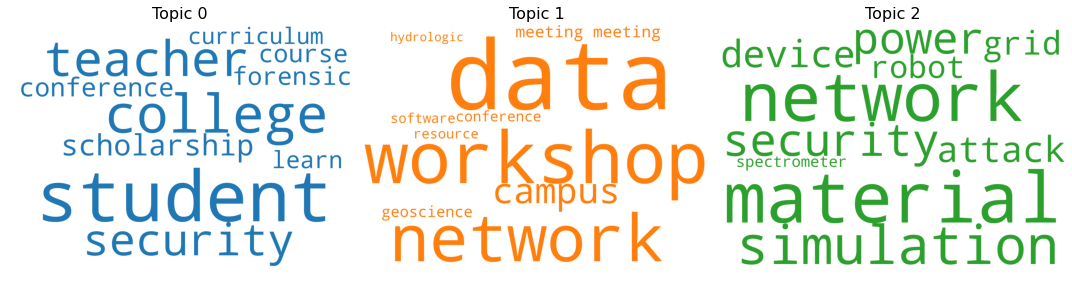

In [161]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(1, 3, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = ', '.join(df_cluster_words['TopicWords'][i])
    cloud.generate(topic_words)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()